In [83]:
import pandas as pd
import seaborn as sns
import re
import nltk
from nltk import FreqDist
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ryanz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [85]:
df = pd.read_csv("hasil_charlie_kirk_die.csv")
tweets = df['full_text'].astype(str).tolist()

In [ ]:
stop_words = set(stopwords.words("indonesian"))
custom_stopwords = {'yg'}
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"@\w+|#\w+", '', text)
    text = re.sub(r"[^a-z\s]", '', text)
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words.union(custom_stopwords)]
    stemmed_tokens = [stemmer.stem(w) for w in tokens]

    return stemmed_tokens

tweets = [
    "Saya sedang berlari-lari kecil di lapangan!",
    "Anak-anak bermain sepakbola dengan gembira.",
    "Belajar Python itu menyenangkan sekali :)"
]

cleaned_tweets = [clean_text(t) for t in tweets]
print(cleaned_tweets)

[['berlarilari', 'lapang'], ['anakanak', 'main', 'sepakbola', 'gembira'], ['ajar', 'python', 'senang']]


In [ ]:
stop_words = set(stopwords.words("english"))
custom_stopwords = {"rt", "amp", "lol", "omg"}
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"@\w+|#\w+", '', text)
    text = re.sub(r"[^a-z\s]", '', text)
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words.union(custom_stopwords)]
    lemmatized_tokens = [lemmatizer.lemmatize(w) for w in tokens]

    return lemmatized_tokens

cleaned_tweets = [clean_text(t) for t in tweets]

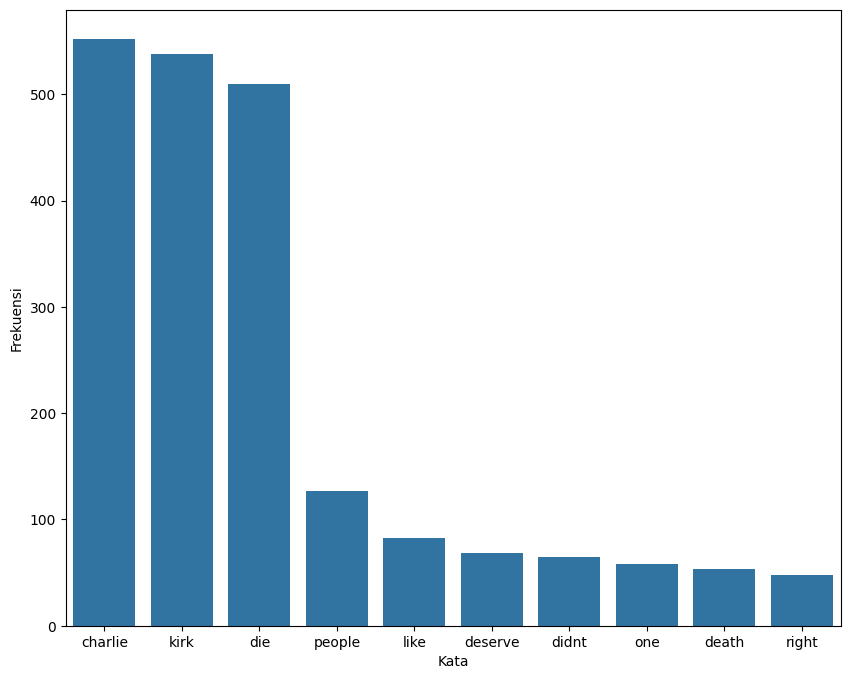

In [95]:
all_words = [word for tweet in cleaned_tweets for word in tweet]

fdist = FreqDist(all_words)
kata_sering = fdist.most_common(10)
word_freq = pd.DataFrame(kata_sering, columns=['Kata', 'Frekuensi'])

plt.figure(figsize=(10, 8))
sns.barplot(x='Kata', y='Frekuensi', data=word_freq)
plt.xlabel('Kata')
plt.ylabel('Frekuensi')
plt.show()

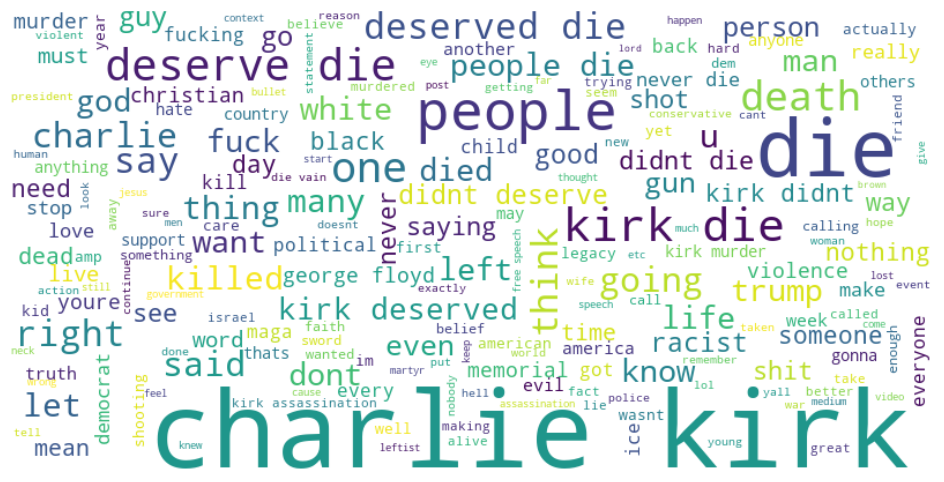

In [88]:
text_string = " ".join(all_words)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_string)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [89]:
w2v_model = Word2Vec(sentences=cleaned_tweets, vector_size=200, window=10, min_count=5, workers=4)

def get_tweet_vector(words, model):
    vecs = [model.wv[w] for w in words if w in model.wv]
    if len(vecs) == 0:
        return [0]*model.vector_size
    return sum(vecs)/len(vecs)

tweet_vectors = [get_tweet_vector(t, w2v_model) for t in cleaned_tweets]

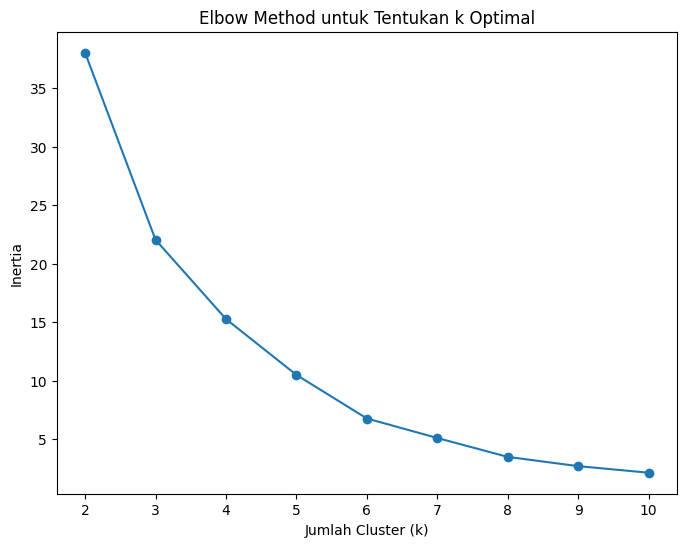

In [90]:
inertias = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(tweet_vectors)
    inertias.append(km.inertia_)

plt.figure(figsize=(8,6))
plt.plot(K_range, inertias, marker="o")
plt.xlabel("Jumlah Cluster (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method untuk Tentukan k Optimal")
plt.show()

In [91]:
k_optimal = 4
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
labels = kmeans.fit_predict(tweet_vectors)
df = df.copy()
df["cluster"] = labels

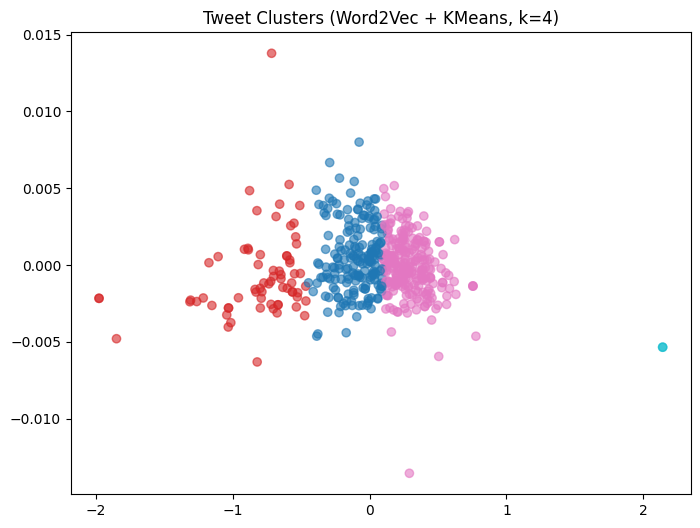

In [92]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(tweet_vectors)

plt.figure(figsize=(8,6))
plt.scatter(reduced[:,0], reduced[:,1], c=labels, cmap="tab10", alpha=0.6)
plt.title(f"Tweet Clusters (Word2Vec + KMeans, k={k_optimal})")
plt.show()

In [93]:
for c in range(k_optimal):
    print(f"\n=== Cluster {c} ===")
    print(df[df["cluster"]==c]["full_text"].head(5).tolist())


=== Cluster 0 ===
['@Smil3yAngel @StevePPhill That s absurd. Who wants to miss out on a place where you can die of smallpox get killed in a shopping mallby a total stranger get lynched or get sent to Uganda if you make a comment about Charlie Kirk?', "@Revolt_In_Red @bennyjohnson Good. That is righteous anger and anger is a positive emotion that moves you TOWARD a stimulus. Fear is the negative counter-part moving you AWAY. These people are not like us. Charlie Kirk's assassination proved it. They only ever lie because they want us all to die. https://t.co/wUioUpUFVV", '@PatriciaHeaton Charlie Kirk was a cunt. But nobody deserves to die like that. Oh except a cunt like Charlie Kirk.', 'Charlie Kirk didn t die in vain. Charlie Kirk was The Lords messenger. Through him Charlie was able to bring hundreds of thousands of people to The Lord Jesus Christ! Amen! #JesusIsKing #God #Lord #RIP #CharlieKirk', 'https://t.co/FTpzoL1OAp this woman said that Charlie Kirk deserve to die and that they

In [94]:
score = silhouette_score(tweet_vectors, labels)
print(f"Silhouette Score untuk {k_optimal} cluster: {score:.4f}")

Silhouette Score untuk 4 cluster: 0.5626
